## BERT Sentiment analysis
### - using stanford AI imdb review data (https://ai.stanford.edu/)

In [1]:
import os
import shutil
import tarfile
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [8]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)
    return pd.DataFrame.from_dict(data)

current_folder = os.getcwd()
dataset_dir = os.path.join(current_folder, 'aclImdb')

# Check if the dataset already exists
if not os.path.exists(dataset_dir):
    # Download and extract dataset
    dataset = tf.keras.utils.get_file(
        fname="aclImdb.tar.gz", 
        origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
        cache_dir=current_folder,
        extract=True)
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# Load the datasets
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

train_df = load_dataset(train_dir)
test_df = load_dataset(test_dir)

print(train_df.head())
print(test_df.head())


                                            sentence  sentiment
0  Story of a man who has unnatural feelings for ...          0
1  Airport '77 starts as a brand new luxury 747 p...          0
2  This film lacked something I couldn't put my f...          0
3  Sorry everyone,,, I know this is supposed to b...          0
4  When I was little my parents took me along to ...          0
                                            sentence  sentiment
0  Once again Mr. Costner has dragged out a movie...          0
1  This is an example of why the majority of acti...          0
2  First of all I hate those moronic rappers, who...          0
3  Not even the Beatles could write songs everyon...          0
4  Brass pictures (movies is not a fitting word f...          0


In [11]:
sentiment_counts = train_df['sentiment'].value_counts()
 
fig =px.bar(x= {0:'Negative',1:'Positive'},
            y= sentiment_counts.values,
            color=sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Sentiments Counts')
 
fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')
 
# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)

'Sentiments Counts.html'

In [12]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [13]:
# Function to randomly select a subset of the data
def select_data_subset(dataframe, fraction=0.1):
    return dataframe.sample(frac=fraction)

# Select a subset of the training data
fraction = 0.1  # e.g., 10% of the data
train_df = select_data_subset(train_df, fraction=fraction)

# Clean the subset of the training data
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()

C:\Users\harry\AppData\Local\Temp\ipykernel_11736\3524044076.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [14]:
# Train dataset
# train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

C:\Users\harry\AppData\Local\Temp\ipykernel_11736\3524044076.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [15]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=set(STOPWORDS), 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

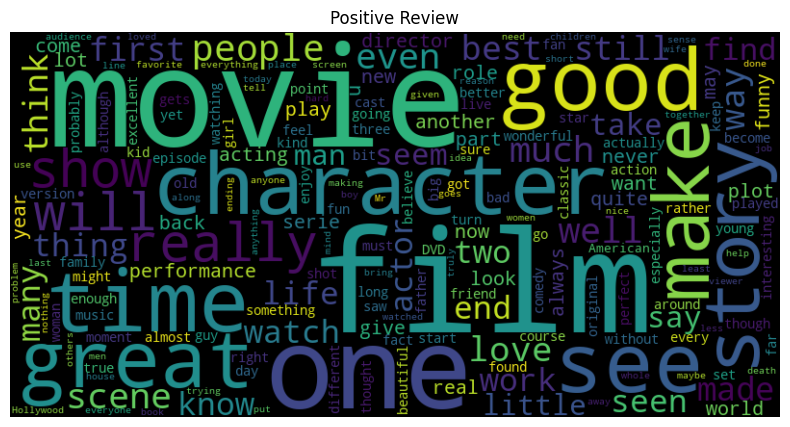

In [16]:
# positive reviews
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

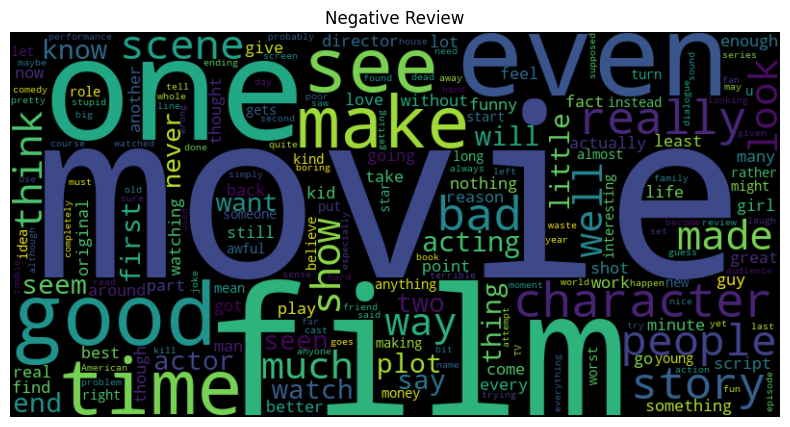

In [17]:
# negative reviews
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [18]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']
 
# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [19]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5, 
                                                    stratify = test_targets)

In [20]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [21]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [33]:
k = 0
print('Training Comments -->>',Reviews.iloc[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target.iloc[k])

Training Comments -->> There are no spoilers in this review There's nothing to spoilNo plot, nothing most clip shows at least try to tie the clips into the plot by some tenuous stretch, but this didn't even do that Clips, three lines to lead into the next interminable sequence of dull clips OK, so perhaps they were short on production time, but they'd have been better off skipping this episode entirely What a waste of timeI'm not sure how this got made, in fact Scrubs is usually much better at subverting tropes, but somehow this got throughThank heavens they were back on form by the next episode

Input Ids -->>
 tf.Tensor(
[  101  2045  2024  2053 27594  2545  1999  2023  3319  2045  1005  1055
  2498  2000 27594  3630  5436  1010  2498  2087 12528  3065  2012  2560
  3046  2000  5495  1996 15281  2046  1996  5436  2011  2070  2702  8918
  7683  1010  2021  2023  2134  1005  1056  2130  2079  2008 15281  1010
  2093  3210  2000  2599  2046  1996  2279  6970 22311  3468  5537  1997
 106

In [34]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [37]:
# original batch size
# batch_size = 32
# resize the batch size
batch_size = 16
# Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Target,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=batch_size,
	epochs=1, # due to no GPU laptop, run only 1 epoch :(
    verbose = 1
)

157/157 [==============================] - 5273s 34s/step - loss: 0.3309 - accuracy: 0.8676 - val_loss: 0.3339 - val_accuracy: 0.8590


In [38]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

391/391 [==============================] - 4619s 12s/step - loss: 0.3508 - accuracy: 0.8530
Test loss: 0.35076072812080383, Test accuracy: 0.8530399799346924


In [39]:
path = 'path-to-save'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')

In [40]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

Some layers from the model checkpoint at path-to-save/Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at path-to-save/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [41]:
pred = bert_model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	1: 'positive',
	0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])

391/391 [==============================] - 2434s 6s/step
Predicted Label : ['Negative', 'positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'positive', 'positive', 'Negative']
Actual Label : ['Negative', 'Negative', 'Negative', 'Negative', 'positive', 'Negative', 'positive', 'positive', 'positive', 'Negative']


In [42]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      6250
    positive       0.85      0.85      0.85      6250

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



In [43]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
	# Convert Review to a list if it's not already a list
	if not isinstance(Review, list):
		Review = [Review]

	Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
																			padding=True,
																			truncation=True,
																			max_length=128,
																			return_tensors='tf').values()
	prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

	# Use argmax along the appropriate axis to get the predicted labels
	pred_labels = tf.argmax(prediction.logits, axis=1)

	# Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
	pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
	return pred_labels


## Final sentiment analysis on user input

In [44]:
Review ='''I am thoroughly impressed with the UCSD Cognitive Science program;
the diverse range of courses offered and the expertise of the faculty have significantly
 enhanced my understanding and passion for the field.'''
Get_sentiment(Review)

1/1 [==============================] - 4s 4s/step


['positive']